In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

In [39]:
titanic_df = pd.read_csv("train.csv", index_col=0)
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
train_df, test_df = train_test_split(titanic_df, random_state=123, test_size=0.2)

In [41]:
n_train_samples = train_df.shape[0]
n_test_samples = test_df.shape[0]
print(n_train_samples, n_test_samples)

712 179


In [42]:
X_train = train_df.drop(columns=["Name", "Ticket", "Survived", "Cabin"])
y_train = train_df['Survived']
X_test = test_df.drop(columns=["Name", "Ticket", "Survived", "Cabin"])
y_test = test_df['Survived']

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols)
    ]
)

In [45]:
# score = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)
# dt_scores_df = pd.DataFrame(score)
# print(dt_scores_df)
# print(dt_scores_df[["train_score", "test_score"]].mean())


In [50]:
depths = np.arange(1, 26)

results = [] 

for d in depths:
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=d, random_state=123))
    ])
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=10,
        return_train_score=True
    )
    
    results.append({
        "max_depth": d,
        "mean_train_score": scores["train_score"].mean(),
        "mean_cv_score": scores["test_score"].mean()
    })
results_df = pd.DataFrame(results).set_index("max_depth")
results_df

,mean_train_score,mean_cv_score
max_depth,,
1,0.783708,0.783685
2,0.791978,0.782316
3,0.822251,0.813204
4,0.834582,0.817430
5,0.845193,0.799061
6,0.866574,0.807512
7,0.885143,0.803286
8,0.902465,0.806142
9,0.920724,0.799061


In [51]:
best_max_depth = results_df["mean_cv_score"].idxmax()
print("Best max_depth:", best_max_depth)

best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=best_max_depth, random_state=123))
])

best_model.fit(X_train, y_train)

Best max_depth: 4


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


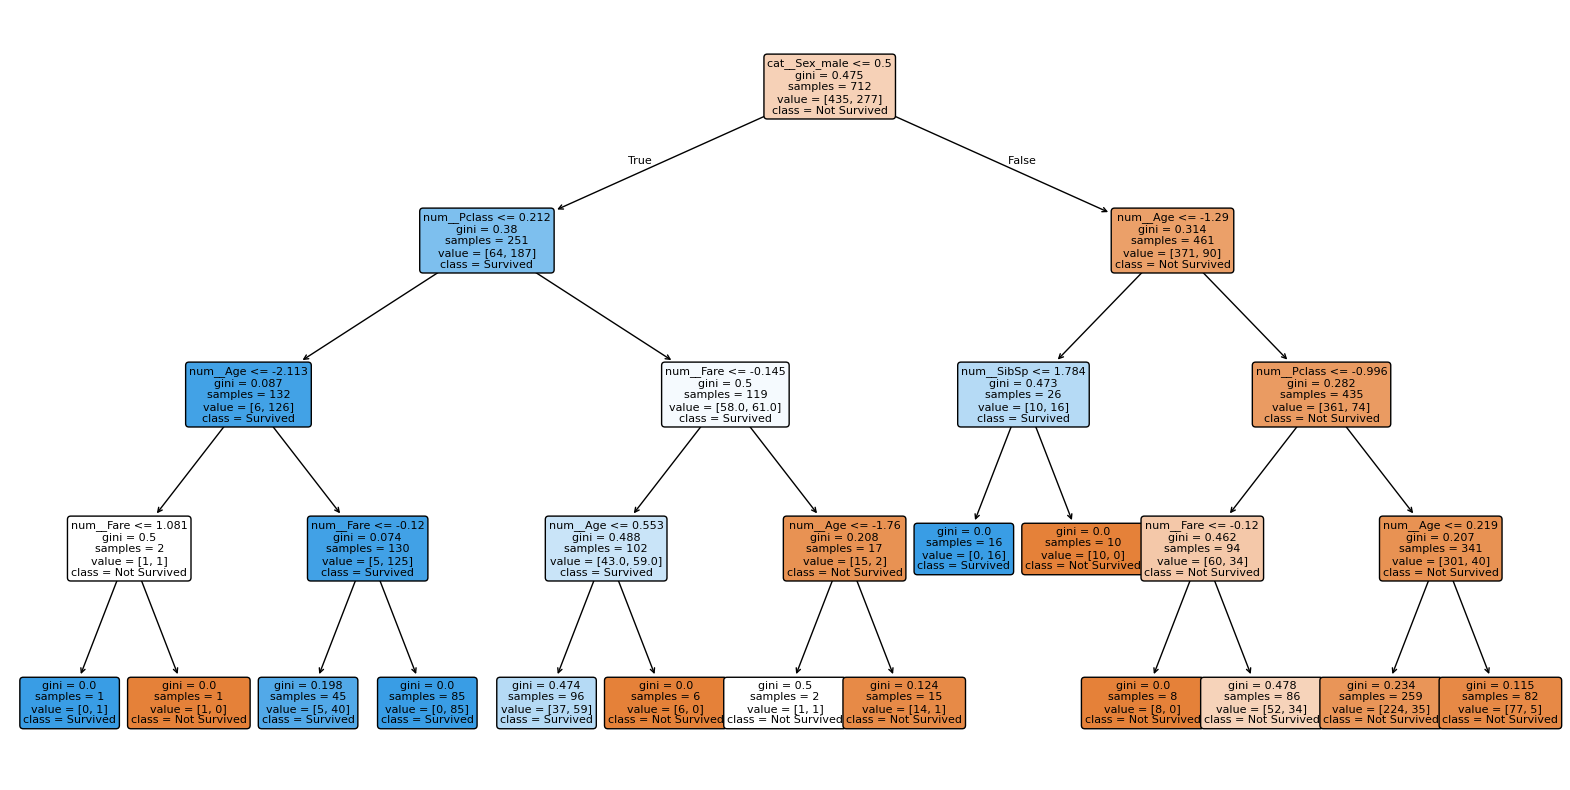

In [52]:
trained_tree = best_model.named_steps["model"]
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

from sklearn import tree

plt.figure(figsize=(20, 10))  # make plot big enough
tree.plot_tree(
    trained_tree,
    feature_names=feature_names,
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


In [53]:
test_score = best_model.score(X_test, y_test)
print("Test score:", test_score)

Test score: 0.8435754189944135


In [54]:
titanic_test_df = pd.read_csv("test.csv", index_col=0)

In [57]:
X = titanic_test_df.drop(columns=["Name", "Ticket", "Cabin"])

predictions = best_model.predict(X)
print(predictions[:10])

[0 0 0 0 1 0 1 0 1 0]
